In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm
import os

2025-05-13 08:22:31.915355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747124552.136354      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747124552.199649      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Global Variables

In [2]:
LATENT_DIM = 100
BATCH_SIZE = 64

# Preparing Dataset

## Loading Paths

In [3]:
ds_path = "/kaggle/input/cat-dataset"
images_path = []

for folder in os.listdir(ds_path):
    for file in os.listdir(os.path.join(ds_path, folder)):
        if file[-3:] == "jpg":
            images_path.append(os.path.join(ds_path, folder, file))

## Loading files as tf.data

In [4]:
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [32, 32])
    return img

In [5]:
list_ds = tf.data.Dataset.from_tensor_slices(images_path)

AUTOTUNE = tf.data.AUTOTUNE


ds = list_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
final_ds = ds.shuffle(buffer_size=1000).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1747124566.263776      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747124566.264486      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Building Models

In [6]:
def generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=2, padding="same", use_bias=False, activation="tanh")
    ])
    return model

In [7]:
def discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=2, input_shape=(32, 32, 3), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [8]:
generator = generator_model()
discriminator = discriminator_model()

generator_optim = tf.keras.optimizers.Adam(1e-4)
discriminator_optim = tf.keras.optimizers.Adam(1e-4)
binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss
def generator_loss(fake_output):
    fake_loss = binary_crossentropy(tf.ones_like(fake_output), fake_output)
    return fake_loss

In [10]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_image = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_image, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optim.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optim.apply_gradients(zip(disc_grads, discriminator.trainable_variables))


Training epoch: 1:   0%|          | 0/157 [00:00<?, ?it/s]E0000 00:00:1747124575.816363      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1747124576.069631      59 cuda_dnn.cc:529] Loaded cuDNN version 90300
Training epoch: 1: 100%|██████████| 157/157 [00:45<00:00,  3.48it/s]


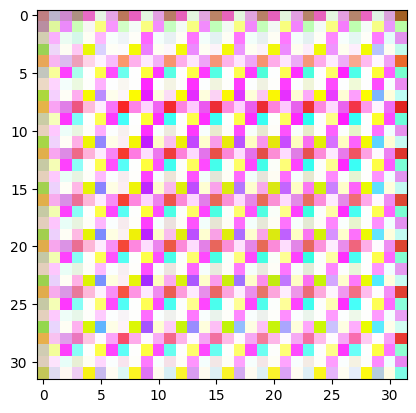

Training epoch: 10: 100%|██████████| 157/157 [00:04<00:00, 36.47it/s]


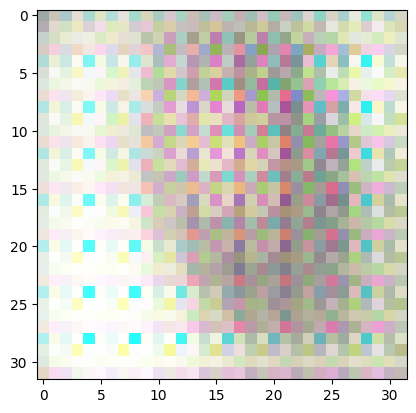

Training epoch: 100: 100%|██████████| 157/157 [00:04<00:00, 36.38it/s]


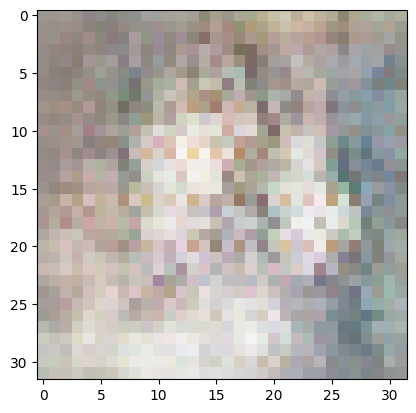

Training epoch: 500: 100%|██████████| 157/157 [00:04<00:00, 36.59it/s]


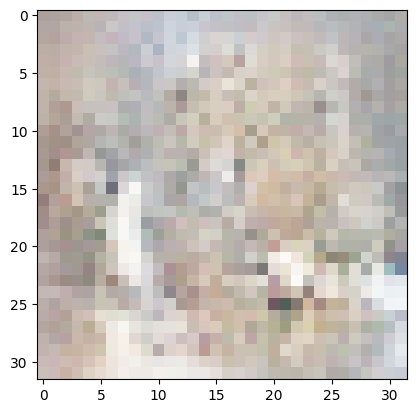

Training epoch: 1000: 100%|██████████| 157/157 [00:04<00:00, 36.44it/s]


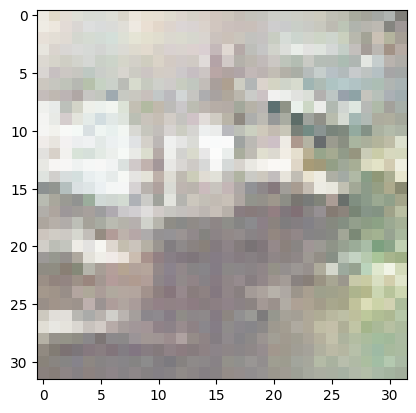

Training epoch: 2000: 100%|██████████| 157/157 [00:04<00:00, 36.50it/s]


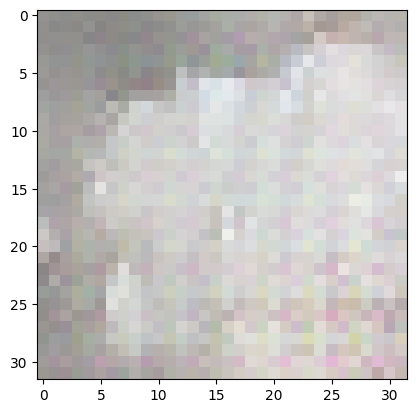

Training epoch: 3000: 100%|██████████| 157/157 [00:04<00:00, 36.34it/s]


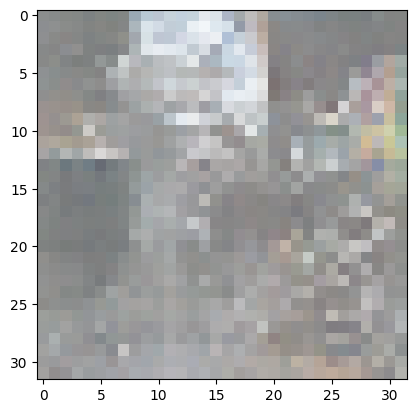

Training epoch: 4000: 100%|██████████| 157/157 [00:04<00:00, 36.49it/s]


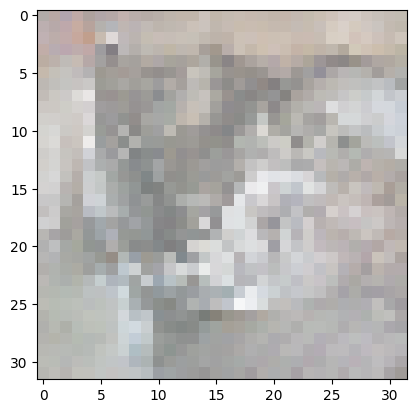

In [11]:
checkpoints = [1, 10, 100, 500, 1000, 2000, 3000, 4000]
def train(epochs):
    for epoch in range(epochs):
        for image_batch in tqdm(final_ds, desc=f"Training epoch: {epoch+1}"):
            train_step(image_batch)
        
        if (epoch+1) in checkpoints:
            out = generator(tf.random.normal([1, LATENT_DIM]))
            plt.imshow((out[0] + 1) / 2)
            plt.show()

train(4000)
generator.save("generator.h5")